### Blurring : Generate A (represent as T)

[[0.17857143 0.16157811 0.11970001 ... 0.         0.         0.        ]
 [0.16157811 0.17857143 0.16157811 ... 0.         0.         0.        ]
 [0.11970001 0.16157811 0.17857143 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.17857143 0.16157811 0.11970001]
 [0.         0.         0.         ... 0.16157811 0.17857143 0.16157811]
 [0.         0.         0.         ... 0.11970001 0.16157811 0.17857143]]


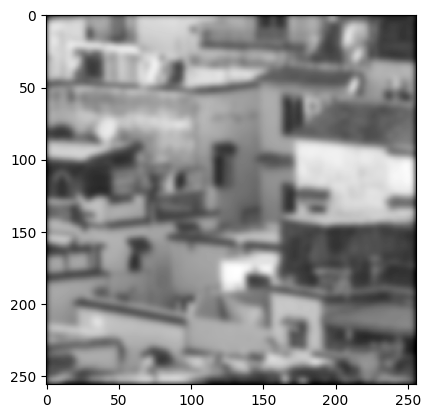

In [3]:
import numpy as np
import scipy.io
from PIL import Image
import time
from matplotlib import image
from matplotlib import pyplot as plt
from scipy.linalg import lu_factor, lu_solve
from sklearn.datasets import load_wine


def image_process(L):
    im = Image.open(L) 
    im = im.convert('L')
    img = np.array(im)
    img = img.astype(np.float64) / 256
    return img

        
def toeplitz(i,T,img):
    t = []
    for k in range(T.shape[1]):
        # t.append(np.exp(-0.1*(i-k)**2))
        T[i,k] = 1/5.6*np.exp(-0.1*(i-k)**2)
    # c = 1/sum(t)
    # for j in range(T.shape[0]):
        # T[i,j] = 1/5.6*t[j]
    return T


L = "D:\\Download\\test_images\\test_images\\256_256_buildings.png"

img = image_process(L)

T = np.zeros([img.shape[0],img.shape[1]])

for i in range(img.shape[0]):
    T = toeplitz(i,T,img)

print(T)
B = T @ img @ T.T

plt.imshow(B,cmap = 'gray')
plt.show()


### Phase I

In [4]:
import numpy as np
# This program is to transform A into bidiagonal form utilizing householder

def householder(b_r,length): # b is a vector that we want to only preserve b1, length is the longtitude of b_r
    beta = np.linalg.norm(b_r)
    v = np.array([0.0 for i in range(length)])
    if (b_r[1:]==0).all():
        return np.identity(length), b_r[0]
    v[0] = (np.abs(b_r[0])+beta)*np.sign(b_r[0])
    v[1:] = b_r[1:]
    H = np.identity(length)-(2/(np.inner(v,v)))*np.outer(v,v.T)
    #print(H@b_r)
    return H,-1*np.sign(b_r[0])*beta  #np.identity(length)-(2/(np.linalg.norm(b_r)**2))*np.outer(b_r,b_r)

def Bidiagonalization(A):
    row,col=np.shape(A)
    diff = row-col #find shape
    H_all_U = np.identity(row)
    H_all_V = np.identity(col)
    if diff >= -1 :
        for i in range(col-2):
            H1 = np.identity(row)
            H2 = np.identity(col)
            H_U, entry_u = householder(A[i:,i],row-i) #gen U
            A[i,i] = entry_u
            A[i+1:,i] = 0
            A[i:,i+1:] = np.matmul(H_U,A[i:,i+1:]) #update A utilizing U  列+1
            H1[i:,i:] = H_U
            H_all_U = H1@H_all_U
            #print(np.round(A,4))
            H_V, entry_v = householder(A[i,i+1:],col-i-1) # gen V
            A[i,i+1] = entry_v
            A[i,i+2:] = 0
            A[i+1:,i+1:] = A[i+1:,i+1:]@H_V #行-1
            H2[i+1:,i+1:] = H_V
            H_all_V = H_all_V@H2
            #print(np.round(A,4))
        if diff == -1:
            return A,H_all_U,H_all_V
        elif diff == 0:
            H1 = np.identity(row)
            H_U, entry_u = householder(A[row-2:,col-2],2)
            A[row-2,row-2] = entry_u
            A[row-1,row-2] = 0.0
            A[row-2:,row-1:] = H_U@A[row-2:,row-1:] #lie-1
            H1[row-2:,row-2:] = H_U
            H_all_U = H1@H_all_U
            return A,H_all_U,H_all_V
        else:
            H1 = np.identity(row)
            H_U, entry_u = householder(A[col-2:,col-2],diff+2)
            A[col-2,col-2] = entry_u
            A[col-1:,col-2] = 0.0
            #print(A)
            #print(A[col-1:,col-1],H_U)
            A[col-2:,col-1:] = H_U@A[col-2:,col-1:] #lie-1
            H1[col-2:,col-2:] = H_U
            H_all_U = H1@H_all_U
            H1 = np.identity(row)
            H_U, entry_u = householder(A[col-1:,col-1],diff+1)
            A[col-1,col-1] = entry_u
            A[col:,col-1] = 0.0
            A[col-1:,col] = H_U@A[col-1:,col] #lie-1
            H1[col-1:,col-1:] = H_U
            H_all_U = H1@H_all_U
            return A,H_all_U,H_all_V
    else:
        for i in range(row-1):
            H1 = np.identity(row)
            H2 = np.identity(col)
            H_U, entry_u = householder(A[i:,i],row-i) #gen U
            A[i,i] = entry_u
            A[i+1:,i] = 0
            A[i:,i+1:] = np.matmul(H_U,A[i:,i+1:]) #update A utilizing U  列-1
            #print(np.round(A,4))
            H1[i:,i:] = H_U
            H_all_U = H1@H_all_U
            H_V, entry_v = householder(A[i,i+1:],col-i-1) # gen V
            A[i,i+1] = entry_v
            A[i,i+2:] = 0
            A[i+1:,i+1:] = A[i+1:,i+1:]@H_V #行-1
            #print(np.round(A,4))
            H2[i+1:,i+1:] = H_V
            H_all_V = H_all_V@H2
        H2 = np.identity(col)
        H_V, entry_v = householder(A[row-1,row:],2)
        A[row-1,row:] = A[row-1,row:]@H_V
        H2[col-2:,col-2:] = H_V
        H_all_V = H_all_V@H2
        return A,H_all_U,H_all_V #return result, U,V(no need to do the transpose)


### Phase II A

In [9]:

# 第二问,求∑
def WilkinsonShift(X):
    sigma = (X[0,0]-X[1,1])/2
    # 如果这么计算是正确的，回头还要考虑加上 (abs(sigma) + np.sqrt((sigma**2)+(X[0,1]**2))=0 的情况
    if sigma > 0:
        ratio = X[1,1] - (X[0,1]**2)/(abs(sigma) + np.sqrt((sigma**2)+(X[0,1]**2)))
    else:
        ratio = X[1,1] + (X[0,1]**2)/(abs(sigma) + np.sqrt((sigma**2)+(X[0,1]**2)))
    return ratio

def QR_factorization(B,U,V):
    T = B.T@B
    Yk = T
    eigenvalues = [0 for i in range(len(T))]
    eigenvector_matrix = np.identity(len(T))
    # deflation
    while len(Yk)>0:
        Q_sum = np.identity(len(Yk))
        if len(Yk) == 1:
            eigenvalues[0] = Yk[0,0]
            Qk = Yk
        else:
            n = np.shape(Yk)[0] #Yk的size
            # Wilkinson shift
            ratio = WilkinsonShift(Yk)
            flag = 1
            while flag:
                Yk_1 = Yk
                Qk, Rk = np.linalg.qr(Yk_1-ratio*np.identity(len(Yk_1)), mode="complete")
                Yk = Rk@Qk + ratio*np.identity(len(Yk_1))
                Q_sum = Q_sum@Qk
                if (np.abs(Yk[-1,-2])) <= 1e-14:
                    flag = 0
            eigenvalues[n-1] = Yk[-1,-1] # convergence完成后储存对应的eigenvalue 
        # 获取eigenvector
        Q = np.identity(len(T))
        Q[:len(Q_sum), :len(Q_sum)] = Q_sum
        eigenvector_matrix = eigenvector_matrix@Q
        # print(eigenvector_matrix)
        #deflation
        Yk = Yk[:-1, :-1] #更新Yk为上一个matrix的左上角
    eigenvalues = np.sqrt(np.abs(eigenvalues))
    VB = eigenvector_matrix
    idx = np.argsort(eigenvalues)
    eigenvalues.sort()
    eigenvalues = eigenvalues[::-1]
    VB = VB[:,idx[::-1]]
    UB = B@VB@np.diag((1/eigenvalues))
    UA = U.T@UB
#     VA = VB.T@V.T
    VA = V@VB
    return UA,eigenvalues,VA
# VA的输出是v

### Deblurring using phaseII A

1.2671427726745605


C:\Users\26741\AppData\Local\Temp\ipykernel_22592\183076765.py:48: RuntimeWarning: divide by zero encountered in divide
  UB = B@VB@np.diag((1/eigenvalues))


109.4077501296997


C:\Users\26741\AppData\Local\Temp\ipykernel_22592\4197642902.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  s_l[i] = 1/s_l[i]
C:\Users\26741\AppData\Local\Temp\ipykernel_22592\4197642902.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  s_r[i] = 1/s_r[i]


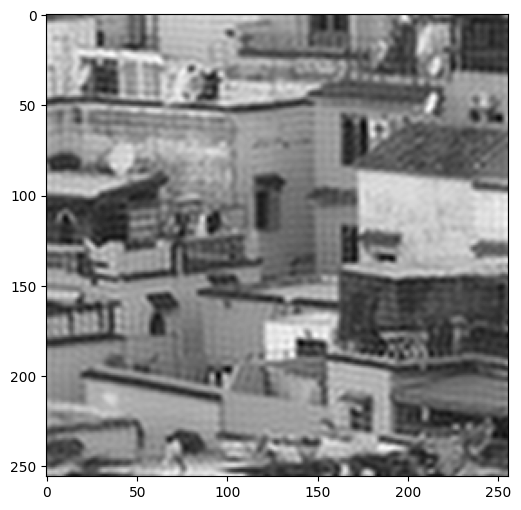

100 100 28.37390962711925 0.1439988613128662


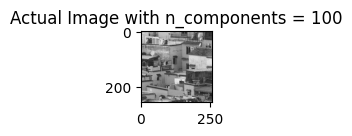

In [10]:
A_l = T.copy()
A_r = T.copy()

tic = time.time()
A_lb,U_L,V_L = Bidiagonalization(A_l)
A_rb,U_R,V_R = Bidiagonalization(A_r)
toc = time.time()
print(toc-tic)

# A_lb = gen_B(A_l,A_lb)
# A_rb = gen_B(A_r,A_rb)

tic - time.time()
u_l,s_l,v_l = QR_factorization(A_lb,U_L,V_L)
u_r,s_r,v_r = QR_factorization(A_rb,U_R,V_R)
toc = time.time()
print(toc-tic)

for i in range(len(s_l)):
#     s_l[i] = np.round(s_l[i],7)
    s_l[i] = 1/s_l[i]
for i in range(len(s_r)):
#     s_r[i] = np.round(s_r[i],7)
    s_r[i] = 1/s_r[i]


# 以下calculating inverse
def pseudoinv(u,s,v,trun):
#     v=v.T
# 这一行在不掉包是删除
    A_t = v[:, :trun] @ np.diag(s[:trun]) @ u.T[:trun, :] 
    return A_t


def frobenius(X):
    return np.sqrt(np.trace(X.T @ X))

def PSNR(n,img,X_t):
    return 10*np.log10(n**2/(frobenius(X_t-img))**2)

comps = [100]
plt.figure(figsize=(12, 6))
blurry = T @ img @ T.T


for i in range(len(comps)):
    for j in range(len(comps)):
        tic = time.time()
        A_lt = pseudoinv(u_l,s_l,v_l,comps[i])
        A_rt = pseudoinv(u_r,s_r,v_r,comps[j])
        X_t = A_lt @ blurry @ A_rt
        plt.imshow(X_t,cmap = 'gray')
        plt.show()
        toc = time.time()
        print(comps[i],comps[j],PSNR(img.shape[0],img,X_t),toc-tic)
    if(i == 0):
        plt.subplot(3, 6, i+1),
        plt.imshow(X_t, cmap='gray'),
        plt.title(f'Actual Image with n_components = {comps[i]}')

    else:
        plt.subplot(3, 6, i+1),
        plt.imshow(X_t, cmap='gray'),
        plt.title(f'n_components = {comps[i]}')

        
plt.show()

In [46]:
G = T.copy()
u,s,v = np.linalg.svd(G)
for i in range(len(s)):
    s[i] = 1/s[i]
trun = 100
v.T[:, :trun] @ np.diag(s[:trun]) @ u.T[:trun, :] 
# u,s,v

array([[ 7.00820439,  0.62841938, -3.88919877, ...,  0.18810537,
         0.08536901, -0.20693076],
       [ 0.62841938,  1.21632683,  0.97206149, ..., -0.07759795,
        -0.03515096,  0.08536901],
       [-3.88919877,  0.97206149,  3.82128412, ..., -0.17099233,
        -0.07759795,  0.18810537],
       ...,
       [ 0.18810537, -0.07759795, -0.17099233, ...,  3.82128412,
         0.97206149, -3.88919877],
       [ 0.08536901, -0.03515096, -0.07759795, ...,  0.97206149,
         1.21632683,  0.62841938],
       [-0.20693076,  0.08536901,  0.18810537, ..., -3.88919877,
         0.62841938,  7.00820439]])

In [50]:
G = T.copy()
u,s,v = np.linalg.svd(G)
for i in range(len(s)):
    s[i] = 1/s[i]
trun = 100
# v.T[:, :trun] @ np.diag(s[:trun]) @ u.T[:trun, :] 

In [51]:
np.round(s,8) == np.round(s_l,8)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True, False, False, False, False,  True, False, False,
       False, False,

In [55]:
x = v_l.T[:, :trun] @ np.diag(s_l[:trun]) 
x

array([[ 2.13027959e-03,  3.07725562e-03,  4.11359503e-03, ...,
         2.80482712e+00,  3.02926826e+00,  3.27350869e+00],
       [-4.25978438e-03, -6.15100516e-03, -8.21832351e-03, ...,
        -2.03067185e+00, -2.12441737e+00, -2.22107294e+00],
       [ 6.38773974e-03,  9.21774574e-03,  1.23053363e-02, ...,
        -1.33463590e+00, -1.53941858e+00, -1.76651052e+00],
       ...,
       [ 0.00000000e+00, -1.18876196e-05,  8.48951711e-05, ...,
        -1.37539928e+00,  2.41056845e+00, -3.27385839e+00],
       [ 0.00000000e+00, -1.40073201e-05,  9.98161124e-05, ...,
        -3.06170484e+00,  3.01975277e+00, -2.52089629e+00],
       [ 0.00000000e+00, -4.45142898e-12,  3.21836152e-11, ...,
        -7.94721359e-02,  9.17991559e-02, -1.06046782e-01]])

### Deblurring using PhaseII B

1.0455782413482666
[[ 7.00820439  0.62841938 -3.88919877 ...  0.18810537  0.08536901
  -0.20693076]
 [ 0.62841938  1.21632683  0.97206149 ... -0.07759795 -0.03515096
   0.08536901]
 [-3.88919877  0.97206149  3.82128412 ... -0.17099233 -0.07759795
   0.18810537]
 ...
 [ 0.18810537 -0.07759795 -0.17099233 ...  3.82128412  0.97206149
  -3.88919877]
 [ 0.08536901 -0.03515096 -0.07759795 ...  0.97206149  1.21632683
   0.62841938]
 [-0.20693076  0.08536901  0.18810537 ... -3.88919877  0.62841938
   7.00820439]]


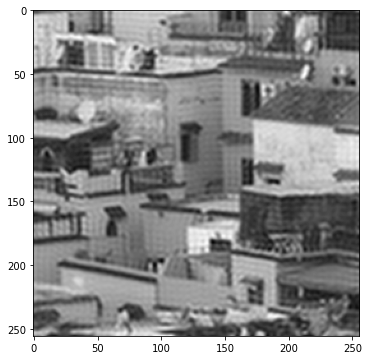

100 100 28.373909627113743 0.12002229690551758
[[ 7.00820439  0.62841938 -3.88919877 ...  0.18810537  0.08536901
  -0.20693076]
 [ 0.62841938  1.21632683  0.97206149 ... -0.07759795 -0.03515096
   0.08536901]
 [-3.88919877  0.97206149  3.82128412 ... -0.17099233 -0.07759795
   0.18810537]
 ...
 [ 0.18810537 -0.07759795 -0.17099233 ...  3.82128412  0.97206149
  -3.88919877]
 [ 0.08536901 -0.03515096 -0.07759795 ...  0.97206149  1.21632683
   0.62841938]
 [-0.20693076  0.08536901  0.18810537 ... -3.88919877  0.62841938
   7.00820439]]


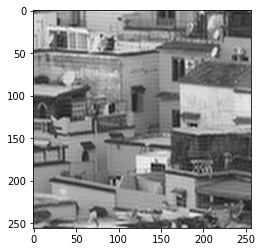

100 120 28.82677618499571 0.10163521766662598
[[ 7.00820439  0.62841938 -3.88919877 ...  0.18810537  0.08536901
  -0.20693076]
 [ 0.62841938  1.21632683  0.97206149 ... -0.07759795 -0.03515096
   0.08536901]
 [-3.88919877  0.97206149  3.82128412 ... -0.17099233 -0.07759795
   0.18810537]
 ...
 [ 0.18810537 -0.07759795 -0.17099233 ...  3.82128412  0.97206149
  -3.88919877]
 [ 0.08536901 -0.03515096 -0.07759795 ...  0.97206149  1.21632683
   0.62841938]
 [-0.20693076  0.08536901  0.18810537 ... -3.88919877  0.62841938
   7.00820439]]


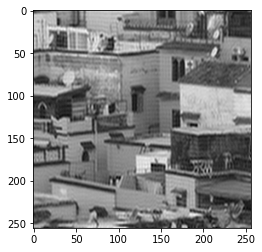

100 150 29.412062995412125 0.0883021354675293
[[ 7.00820439  0.62841938 -3.88919877 ...  0.18810537  0.08536901
  -0.20693076]
 [ 0.62841938  1.21632683  0.97206149 ... -0.07759795 -0.03515096
   0.08536901]
 [-3.88919877  0.97206149  3.82128412 ... -0.17099233 -0.07759795
   0.18810537]
 ...
 [ 0.18810537 -0.07759795 -0.17099233 ...  3.82128412  0.97206149
  -3.88919877]
 [ 0.08536901 -0.03515096 -0.07759795 ...  0.97206149  1.21632683
   0.62841938]
 [-0.20693076  0.08536901  0.18810537 ... -3.88919877  0.62841938
   7.00820439]]


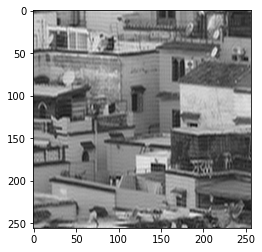

100 175 29.721803013260867 0.08652234077453613
[[ 7.00820439  0.62841938 -3.88919877 ...  0.18810537  0.08536901
  -0.20693076]
 [ 0.62841938  1.21632683  0.97206149 ... -0.07759795 -0.03515096
   0.08536901]
 [-3.88919877  0.97206149  3.82128412 ... -0.17099233 -0.07759795
   0.18810537]
 ...
 [ 0.18810537 -0.07759795 -0.17099233 ...  3.82128412  0.97206149
  -3.88919877]
 [ 0.08536901 -0.03515096 -0.07759795 ...  0.97206149  1.21632683
   0.62841938]
 [-0.20693076  0.08536901  0.18810537 ... -3.88919877  0.62841938
   7.00820439]]


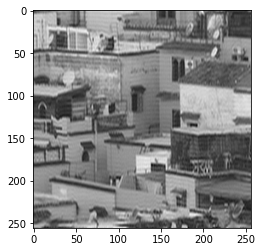

100 200 29.95375407825394 0.09630370140075684
[[ 22.44920639 -12.78433489 -15.50484578 ...   0.33063151   0.77021341
   -0.64313007]
 [-12.78433489  13.61836861  10.65500942 ...  -0.39626613  -0.92212491
    0.77021341]
 [-15.50484578  10.65500942  12.79565208 ...  -0.16965681  -0.39626613
    0.33063151]
 ...
 [  0.33063151  -0.39626613  -0.16965681 ...  12.79565208  10.65500942
  -15.50484578]
 [  0.77021341  -0.92212491  -0.39626613 ...  10.65500942  13.61836861
  -12.78433489]
 [ -0.64313007   0.77021341   0.33063151 ... -15.50484578 -12.78433489
   22.44920639]]


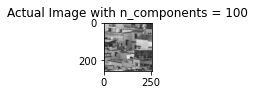

120 100 29.264323608573456 0.07213664054870605
[[ 22.44920639 -12.78433489 -15.50484578 ...   0.33063151   0.77021341
   -0.64313007]
 [-12.78433489  13.61836861  10.65500942 ...  -0.39626613  -0.92212491
    0.77021341]
 [-15.50484578  10.65500942  12.79565208 ...  -0.16965681  -0.39626613
    0.33063151]
 ...
 [  0.33063151  -0.39626613  -0.16965681 ...  12.79565208  10.65500942
  -15.50484578]
 [  0.77021341  -0.92212491  -0.39626613 ...  10.65500942  13.61836861
  -12.78433489]
 [ -0.64313007   0.77021341   0.33063151 ... -15.50484578 -12.78433489
   22.44920639]]


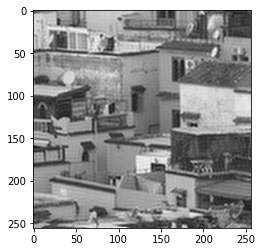

120 120 29.85887970114984 0.07814383506774902
[[ 22.44920639 -12.78433489 -15.50484578 ...   0.33063151   0.77021341
   -0.64313007]
 [-12.78433489  13.61836861  10.65500942 ...  -0.39626613  -0.92212491
    0.77021341]
 [-15.50484578  10.65500942  12.79565208 ...  -0.16965681  -0.39626613
    0.33063151]
 ...
 [  0.33063151  -0.39626613  -0.16965681 ...  12.79565208  10.65500942
  -15.50484578]
 [  0.77021341  -0.92212491  -0.39626613 ...  10.65500942  13.61836861
  -12.78433489]
 [ -0.64313007   0.77021341   0.33063151 ... -15.50484578 -12.78433489
   22.44920639]]


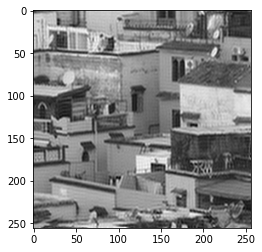

120 150 30.666488283342318 0.0937347412109375
[[ 22.44920639 -12.78433489 -15.50484578 ...   0.33063151   0.77021341
   -0.64313007]
 [-12.78433489  13.61836861  10.65500942 ...  -0.39626613  -0.92212491
    0.77021341]
 [-15.50484578  10.65500942  12.79565208 ...  -0.16965681  -0.39626613
    0.33063151]
 ...
 [  0.33063151  -0.39626613  -0.16965681 ...  12.79565208  10.65500942
  -15.50484578]
 [  0.77021341  -0.92212491  -0.39626613 ...  10.65500942  13.61836861
  -12.78433489]
 [ -0.64313007   0.77021341   0.33063151 ... -15.50484578 -12.78433489
   22.44920639]]


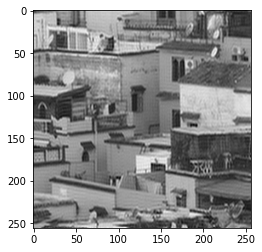

120 175 31.113532113797607 0.11571741104125977
[[ 22.44920639 -12.78433489 -15.50484578 ...   0.33063151   0.77021341
   -0.64313007]
 [-12.78433489  13.61836861  10.65500942 ...  -0.39626613  -0.92212491
    0.77021341]
 [-15.50484578  10.65500942  12.79565208 ...  -0.16965681  -0.39626613
    0.33063151]
 ...
 [  0.33063151  -0.39626613  -0.16965681 ...  12.79565208  10.65500942
  -15.50484578]
 [  0.77021341  -0.92212491  -0.39626613 ...  10.65500942  13.61836861
  -12.78433489]
 [ -0.64313007   0.77021341   0.33063151 ... -15.50484578 -12.78433489
   22.44920639]]


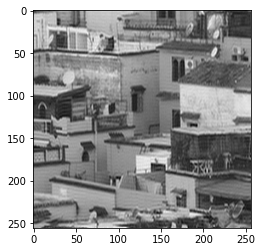

120 200 31.46245050474857 0.09337735176086426
[[ 118.25744241 -207.35730002   74.92817    ...   -6.78515501
     7.96974923   -3.12959889]
 [-207.35730002  421.76207293 -200.03735998 ...   17.27389412
   -20.29381548    7.96974924]
 [  74.92817    -200.03735998  155.13692651 ...  -14.6961746
    17.27389417   -6.78515504]
 ...
 [  -6.78515495   17.27389398  -14.69617448 ...  155.13692587
  -200.03735956   74.9281699 ]
 [   7.96974917  -20.29381532   17.27389404 ... -200.03735956
   421.76207316 -207.35730025]
 [  -3.12959887    7.96974918   -6.78515498 ...   74.9281699
  -207.35730025  118.25744257]]


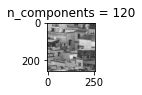

150 100 30.309225839808136 0.05501723289489746
[[ 118.25744241 -207.35730002   74.92817    ...   -6.78515501
     7.96974923   -3.12959889]
 [-207.35730002  421.76207293 -200.03735998 ...   17.27389412
   -20.29381548    7.96974924]
 [  74.92817    -200.03735998  155.13692651 ...  -14.6961746
    17.27389417   -6.78515504]
 ...
 [  -6.78515495   17.27389398  -14.69617448 ...  155.13692587
  -200.03735956   74.9281699 ]
 [   7.96974917  -20.29381532   17.27389404 ... -200.03735956
   421.76207316 -207.35730025]
 [  -3.12959887    7.96974918   -6.78515498 ...   74.9281699
  -207.35730025  118.25744257]]


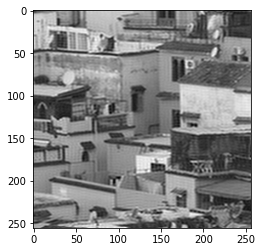

150 120 31.12841454929466 0.1466367244720459
[[ 118.25744241 -207.35730002   74.92817    ...   -6.78515501
     7.96974923   -3.12959889]
 [-207.35730002  421.76207293 -200.03735998 ...   17.27389412
   -20.29381548    7.96974924]
 [  74.92817    -200.03735998  155.13692651 ...  -14.6961746
    17.27389417   -6.78515504]
 ...
 [  -6.78515495   17.27389398  -14.69617448 ...  155.13692587
  -200.03735956   74.9281699 ]
 [   7.96974917  -20.29381532   17.27389404 ... -200.03735956
   421.76207316 -207.35730025]
 [  -3.12959887    7.96974918   -6.78515498 ...   74.9281699
  -207.35730025  118.25744257]]


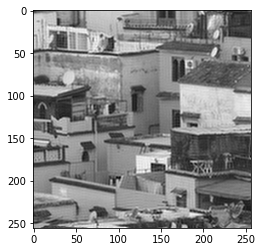

150 150 32.33196117235646 0.10283684730529785
[[ 118.25744241 -207.35730002   74.92817    ...   -6.78515501
     7.96974923   -3.12959889]
 [-207.35730002  421.76207293 -200.03735998 ...   17.27389412
   -20.29381548    7.96974924]
 [  74.92817    -200.03735998  155.13692651 ...  -14.6961746
    17.27389417   -6.78515504]
 ...
 [  -6.78515495   17.27389398  -14.69617448 ...  155.13692587
  -200.03735956   74.9281699 ]
 [   7.96974917  -20.29381532   17.27389404 ... -200.03735956
   421.76207316 -207.35730025]
 [  -3.12959887    7.96974918   -6.78515498 ...   74.9281699
  -207.35730025  118.25744257]]


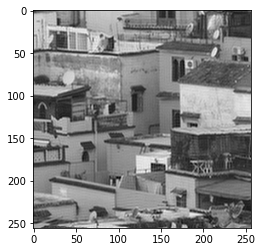

150 175 33.06365882222117 0.1272268295288086
[[ 118.25744241 -207.35730002   74.92817    ...   -6.78515501
     7.96974923   -3.12959889]
 [-207.35730002  421.76207293 -200.03735998 ...   17.27389412
   -20.29381548    7.96974924]
 [  74.92817    -200.03735998  155.13692651 ...  -14.6961746
    17.27389417   -6.78515504]
 ...
 [  -6.78515495   17.27389398  -14.69617448 ...  155.13692587
  -200.03735956   74.9281699 ]
 [   7.96974917  -20.29381532   17.27389404 ... -200.03735956
   421.76207316 -207.35730025]
 [  -3.12959887    7.96974918   -6.78515498 ...   74.9281699
  -207.35730025  118.25744257]]


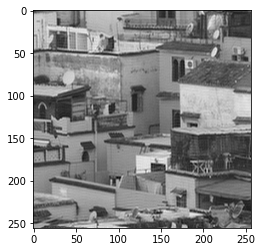

150 200 33.669163273946396 0.1432938575744629
[[  411.9881712  -1159.66260244  1416.20651973 ...    61.75102144
    -35.56687081     9.56115058]
 [-1159.66260241  3540.71046471 -4665.54964119 ...  -229.68757738
    132.30143902   -35.56687132]
 [ 1416.20651965 -4665.54964107  6715.61562208 ...   398.72284589
   -229.68758243    61.75102369]
 ...
 [   61.75101225  -229.68754324   398.72278674 ...  6715.61575276
  -4665.54977562  1416.20656741]
 [  -35.5668655    132.30141932  -229.68754829 ... -4665.54977549
   3540.71058496 -1159.66264331]
 [    9.56114915   -35.56686601    61.7510145  ...  1416.20656734
  -1159.66264329   411.9881849 ]]


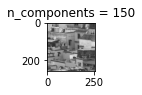

175 100 31.00989478488005 0.050009965896606445
[[  411.9881712  -1159.66260244  1416.20651973 ...    61.75102144
    -35.56687081     9.56115058]
 [-1159.66260241  3540.71046471 -4665.54964119 ...  -229.68757738
    132.30143902   -35.56687132]
 [ 1416.20651965 -4665.54964107  6715.61562208 ...   398.72284589
   -229.68758243    61.75102369]
 ...
 [   61.75101225  -229.68754324   398.72278674 ...  6715.61575276
  -4665.54977562  1416.20656741]
 [  -35.5668655    132.30141932  -229.68754829 ... -4665.54977549
   3540.71058496 -1159.66264331]
 [    9.56114915   -35.56686601    61.7510145  ...  1416.20656734
  -1159.66264329   411.9881849 ]]


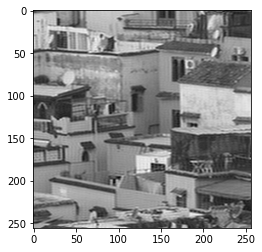

175 120 32.02299002216168 0.0909736156463623
[[  411.9881712  -1159.66260244  1416.20651973 ...    61.75102144
    -35.56687081     9.56115058]
 [-1159.66260241  3540.71046471 -4665.54964119 ...  -229.68757738
    132.30143902   -35.56687132]
 [ 1416.20651965 -4665.54964107  6715.61562208 ...   398.72284589
   -229.68758243    61.75102369]
 ...
 [   61.75101225  -229.68754324   398.72278674 ...  6715.61575276
  -4665.54977562  1416.20656741]
 [  -35.5668655    132.30141932  -229.68754829 ... -4665.54977549
   3540.71058496 -1159.66264331]
 [    9.56114915   -35.56686601    61.7510145  ...  1416.20656734
  -1159.66264329   411.9881849 ]]


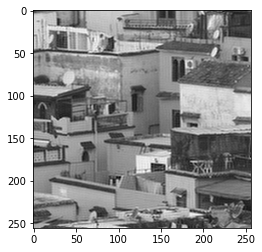

175 150 33.61986448681236 0.09860801696777344
[[  411.9881712  -1159.66260244  1416.20651973 ...    61.75102144
    -35.56687081     9.56115058]
 [-1159.66260241  3540.71046471 -4665.54964119 ...  -229.68757738
    132.30143902   -35.56687132]
 [ 1416.20651965 -4665.54964107  6715.61562208 ...   398.72284589
   -229.68758243    61.75102369]
 ...
 [   61.75101225  -229.68754324   398.72278674 ...  6715.61575276
  -4665.54977562  1416.20656741]
 [  -35.5668655    132.30141932  -229.68754829 ... -4665.54977549
   3540.71058496 -1159.66264331]
 [    9.56114915   -35.56686601    61.7510145  ...  1416.20656734
  -1159.66264329   411.9881849 ]]


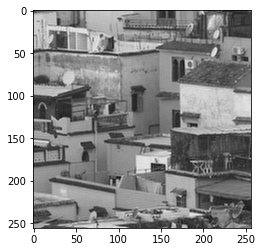

175 175 34.69094843680931 0.16184496879577637
[[  411.9881712  -1159.66260244  1416.20651973 ...    61.75102144
    -35.56687081     9.56115058]
 [-1159.66260241  3540.71046471 -4665.54964119 ...  -229.68757738
    132.30143902   -35.56687132]
 [ 1416.20651965 -4665.54964107  6715.61562208 ...   398.72284589
   -229.68758243    61.75102369]
 ...
 [   61.75101225  -229.68754324   398.72278674 ...  6715.61575276
  -4665.54977562  1416.20656741]
 [  -35.5668655    132.30141932  -229.68754829 ... -4665.54977549
   3540.71058496 -1159.66264331]
 [    9.56114915   -35.56686601    61.7510145  ...  1416.20656734
  -1159.66264329   411.9881849 ]]


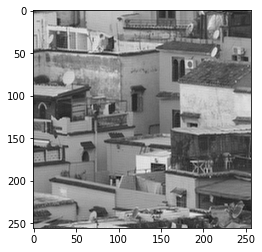

175 200 35.647064618823464 0.08954215049743652
[[ 1.17322626e+03 -4.46718792e+03  8.66190505e+03 ... -2.57402589e+02
   1.03424644e+02 -2.15562118e+01]
 [-4.46718792e+03  1.79817779e+04 -3.65072677e+04 ...  1.23494563e+03
  -4.96213395e+02  1.03424670e+02]
 [ 8.66190504e+03 -3.65072677e+04  7.75298150e+04 ... -3.07336998e+03
   1.23494605e+03 -2.57402740e+02]
 ...
 [-2.57401395e+02  1.23493991e+03 -3.07335572e+03 ...  7.75299131e+04
  -3.65073137e+04  8.66191578e+03]
 [ 1.03424164e+02 -4.96211093e+02  1.23494032e+03 ... -3.65073137e+04
   1.79817994e+04 -4.46719293e+03]
 [-2.15561118e+01  1.03424191e+02 -2.57401547e+02 ...  8.66191577e+03
  -4.46719293e+03  1.17322742e+03]]


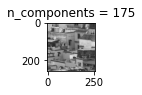

200 100 31.53794448355484 0.05526447296142578
[[ 1.17322626e+03 -4.46718792e+03  8.66190505e+03 ... -2.57402589e+02
   1.03424644e+02 -2.15562118e+01]
 [-4.46718792e+03  1.79817779e+04 -3.65072677e+04 ...  1.23494563e+03
  -4.96213395e+02  1.03424670e+02]
 [ 8.66190504e+03 -3.65072677e+04  7.75298150e+04 ... -3.07336998e+03
   1.23494605e+03 -2.57402740e+02]
 ...
 [-2.57401395e+02  1.23493991e+03 -3.07335572e+03 ...  7.75299131e+04
  -3.65073137e+04  8.66191578e+03]
 [ 1.03424164e+02 -4.96211093e+02  1.23494032e+03 ... -3.65073137e+04
   1.79817994e+04 -4.46719293e+03]
 [-2.15561118e+01  1.03424191e+02 -2.57401547e+02 ...  8.66191577e+03
  -4.46719293e+03  1.17322742e+03]]


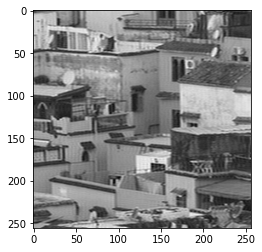

200 120 32.73030612978263 0.09375405311584473
[[ 1.17322626e+03 -4.46718792e+03  8.66190505e+03 ... -2.57402589e+02
   1.03424644e+02 -2.15562118e+01]
 [-4.46718792e+03  1.79817779e+04 -3.65072677e+04 ...  1.23494563e+03
  -4.96213395e+02  1.03424670e+02]
 [ 8.66190504e+03 -3.65072677e+04  7.75298150e+04 ... -3.07336998e+03
   1.23494605e+03 -2.57402740e+02]
 ...
 [-2.57401395e+02  1.23493991e+03 -3.07335572e+03 ...  7.75299131e+04
  -3.65073137e+04  8.66191578e+03]
 [ 1.03424164e+02 -4.96211093e+02  1.23494032e+03 ... -3.65073137e+04
   1.79817994e+04 -4.46719293e+03]
 [-2.15561118e+01  1.03424191e+02 -2.57401547e+02 ...  8.66191577e+03
  -4.46719293e+03  1.17322742e+03]]


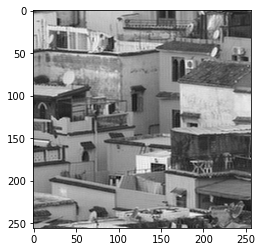

200 150 34.74751858221686 0.11520195007324219
[[ 1.17322626e+03 -4.46718792e+03  8.66190505e+03 ... -2.57402589e+02
   1.03424644e+02 -2.15562118e+01]
 [-4.46718792e+03  1.79817779e+04 -3.65072677e+04 ...  1.23494563e+03
  -4.96213395e+02  1.03424670e+02]
 [ 8.66190504e+03 -3.65072677e+04  7.75298150e+04 ... -3.07336998e+03
   1.23494605e+03 -2.57402740e+02]
 ...
 [-2.57401395e+02  1.23493991e+03 -3.07335572e+03 ...  7.75299131e+04
  -3.65073137e+04  8.66191578e+03]
 [ 1.03424164e+02 -4.96211093e+02  1.23494032e+03 ... -3.65073137e+04
   1.79817994e+04 -4.46719293e+03]
 [-2.15561118e+01  1.03424191e+02 -2.57401547e+02 ...  8.66191577e+03
  -4.46719293e+03  1.17322742e+03]]


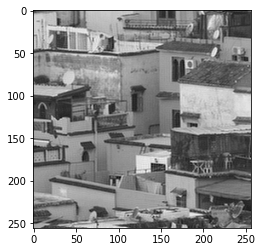

200 175 36.248220661813455 0.11008691787719727
[[ 1.17322626e+03 -4.46718792e+03  8.66190505e+03 ... -2.57402589e+02
   1.03424644e+02 -2.15562118e+01]
 [-4.46718792e+03  1.79817779e+04 -3.65072677e+04 ...  1.23494563e+03
  -4.96213395e+02  1.03424670e+02]
 [ 8.66190504e+03 -3.65072677e+04  7.75298150e+04 ... -3.07336998e+03
   1.23494605e+03 -2.57402740e+02]
 ...
 [-2.57401395e+02  1.23493991e+03 -3.07335572e+03 ...  7.75299131e+04
  -3.65073137e+04  8.66191578e+03]
 [ 1.03424164e+02 -4.96211093e+02  1.23494032e+03 ... -3.65073137e+04
   1.79817994e+04 -4.46719293e+03]
 [-2.15561118e+01  1.03424191e+02 -2.57401547e+02 ...  8.66191577e+03
  -4.46719293e+03  1.17322742e+03]]


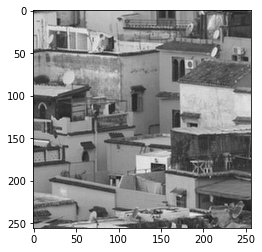

200 200 37.745389316837304 0.12243342399597168


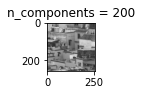

In [6]:
A_l = T.copy()
A_r = T.copy()

tic = time.time()
A_lb,U_L,V_L = Bidiagonalization(A_l)
A_rb,U_R,V_R = Bidiagonalization(A_r)
toc = time.time()
print(toc-tic)


u_l,s_l,v_l = QR_iteration(A_lb,U_L,V_L)
u_r,s_r,v_r = QR_iteration(A_rb,U_R,V_R)


for i in range(len(s_l)):
    s_l[i] = 1/s_l[i]
for i in range(len(s_r)):
    s_r[i] = 1/s_r[i]


# 以下calculating inverse
def pseudoinv(u,s,v,trun):
#     v=v.T
# 这一行在不掉包是删除
    A_t = v[:, :trun] @ np.diag(s[:trun]) @ u.T[:trun, :] 
    return A_t


def frobenius(X):
    return np.sqrt(np.trace(X.T @ X))

def PSNR(n,img,X_t):
    return 10*np.log10(n**2/(frobenius(X_t-img))**2)

comps = [100,120,150,175,200]
plt.figure(figsize=(12, 6))
blurry = T @ img @ T.T


for i in range(len(comps)):
    for j in range(len(comps)):
        tic = time.time()
        A_lt = pseudoinv(u_l,s_l,v_l,comps[i])
        print(A_lt)
        A_rt = pseudoinv(u_r,s_r,v_r,comps[j])
        X_t = A_lt @ blurry @ A_rt
        plt.imshow(X_t,cmap = 'gray')
        plt.show()
        toc = time.time()
        print(comps[i],comps[j],PSNR(img.shape[0],img,X_t),toc-tic)
    if(i == 0):
        plt.subplot(3, 6, i+1),
        plt.imshow(X_t, cmap='gray'),
        plt.title(f'Actual Image with n_components = {comps[i]}')

    else:
        plt.subplot(3, 6, i+1),
        plt.imshow(X_t, cmap='gray'),
        plt.title(f'n_components = {comps[i]}')

        
plt.show()